This notebook trains **fixed-weight** TCN temperature forecasts for a single station from hourly observations:

Outputs:
1) Evaluation on two baseline with MAE and RMSE.
2) A 7-day (168h) forecast images in a **weather-forecast-like** format.
3) Saved models + json files under `point_weights/`

Preprocessing

In [1]:
# =========================================
# 1) Setup
# =========================================
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, List, Tuple, Dict
from sklearn.preprocessing import StandardScaler
import joblib

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Random seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Paths & station
DATA_PATH  = "./H_20_latest-2024-2025.csv"
STATION_ID = 20004002

# Keep quality flags
GOOD_Q_VALUES = {0, 1, 9}

# Lookback & horizon
LOOKBACK = 168
HORIZON  = 168

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [2]:
# =========================================
# 2) Load & Filter
# =========================================
df0 = pd.read_csv(DATA_PATH, sep=";")

# Filter by station
df0 = df0[df0["NUM_POSTE"] == STATION_ID].copy()

# Parse datetime (UTC)
df0["dt"] = pd.to_datetime(
    df0["AAAAMMJJHH"].astype(str),
    format="%Y%m%d%H",
    errors="coerce",
    utc=True
)

# Sort and deduplicate
df0 = df0.sort_values("dt").drop_duplicates(subset=["NUM_POSTE", "dt"]).reset_index(drop=True)

# Reindex to full hourly range
df0 = df0.set_index("dt")
full_idx = pd.date_range(df0.index.min(), df0.index.max(), freq="h", tz="UTC")
df0 = df0.reindex(full_idx)

# Fill static station metadata
for c in ["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "ALTI"]:
    if c in df0.columns:
        df0[c] = df0[c].ffill().bfill()

# Rebuild AAAAMMJJHH from index
df0["AAAAMMJJHH"] = df0.index.strftime("%Y%m%d%H").astype(int)

print("Rows (hourly):", len(df0), "from", df0.index.min(), "to", df0.index.max())

Rows (hourly): 10516 from 2024-01-01 00:00:00+00:00 to 2025-03-14 03:00:00+00:00


In [3]:
# =========================================
# 3) QC functions
# =========================================
def qc_by_flag(df: pd.DataFrame, var: str, good_values=GOOD_Q_VALUES) -> None:
    """
    Filter by quality flag (in-place)
    - if it exsits Q{var}：get it
    - if Q lost or not exsits: good_values -> var sets NaN
    """
    qvar = "Q" + var
    if var not in df.columns or qvar not in df.columns:
        return
    bad = df[qvar].isna() | (~df[qvar].isin(list(good_values)))
    df.loc[bad, var] = np.nan


def physical_checks(df: pd.DataFrame) -> None:
    """
    Minimal physical & spike checks (in-place)
    """
    # Temperature range
    if "T" in df.columns:
        df.loc[(df["T"] < -40.0) | (df["T"] > 55.0), "T"] = np.nan

        # 1-hour jump
        jump = df["T"].diff().abs()
        df.loc[jump > 10.0, "T"] = np.nan

    # Negative precipitation
    if "RR1" in df.columns:
        df.loc[df["RR1"] < 0, "RR1"] = np.nan


def pick_best_var(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """
    Pick the candidate with lowest missing rate
    """
    existing = [c for c in candidates if c in df.columns]
    if not existing:
        return None
    return min(existing, key=lambda c: df[c].isna().mean())

In [4]:
# =========================================
# 4) Apply QC + pick best radiation vars
# =========================================
df = df0.copy()

# Candidate groups
VAR_GROUPS = {
    "GLO_best": ["GLO", "GLO2"],
    "DIR_best": ["DIR", "DIR2"],
}

# QC first for fair comparison
for _, cands in VAR_GROUPS.items():
    for c in cands:
        qc_by_flag(df, c)

# QC common met vars
CANDIDATE_BASE = ["T","TD","U","PMER","PSTAT","FF","DD","RR1","INS","INFRAR","T10","T20","T50"]
for v in CANDIDATE_BASE:
    qc_by_flag(df, v)

# MUST call physical checks
physical_checks(df)

# Pick best radiation columns
GLO_COL = pick_best_var(df, VAR_GROUPS["GLO_best"])
DIR_COL = pick_best_var(df, VAR_GROUPS["DIR_best"])
print("Picked radiation columns:", {"GLO": GLO_COL, "DIR": DIR_COL})

Picked radiation columns: {'GLO': 'GLO', 'DIR': 'DIR'}


TCN Model

In [5]:
# =========================================
# 5) Feature engineering + missing fill
# =========================================
# Time features
df["hour"] = df.index.hour
df["doy"]  = df.index.dayofyear
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24.0)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24.0)
df["doy_sin"]  = np.sin(2*np.pi*df["doy"]/365.25)
df["doy_cos"]  = np.cos(2*np.pi*df["doy"]/365.25)

#  Wind direction features
if "DD" in df.columns:
    dd_rad = np.deg2rad(df["DD"])
    df["DD_sin"] = np.sin(dd_rad)
    df["DD_cos"] = np.cos(dd_rad)

if "FF" in df.columns and "DD_sin" in df.columns:
    df["wind_u"] = df["FF"] * df["DD_sin"]
    df["wind_v"] = df["FF"] * df["DD_cos"]

# Base met features
base_feats = ["T","TD","U","PMER","PSTAT","RR1","FF","INS","INFRAR","T10","T20","T50"]
base_feats = [c for c in base_feats if c in df.columns]

# Add picked radiation columns
if GLO_COL is not None:
    base_feats.append(GLO_COL)
if DIR_COL is not None:
    base_feats.append(DIR_COL)

# Choose wind feats
if "wind_u" in df.columns and "wind_v" in df.columns:
    wind_feats = ["wind_u","wind_v"]
elif "DD_sin" in df.columns and "DD_cos" in df.columns:
    wind_feats = ["DD_sin","DD_cos"]
elif "DD" in df.columns:
    wind_feats = ["DD"]
else:
    wind_feats = []

time_feats = ["hour_sin","hour_cos","doy_sin","doy_cos"]

# Missing masks (before fill)
for v in base_feats:
    df[f"{v}_miss"] = df[v].isna().astype("float32")
miss_feats = [f"{v}_miss" for v in base_feats]

# Final feature list
MODEL_FEATURES = base_feats + wind_feats + time_feats + miss_feats
MODEL_FEATURES = list(dict.fromkeys([c for c in MODEL_FEATURES if c in df.columns]))

TARGET_VAR = "T"
assert TARGET_VAR in df.columns, "Target T not found."

print("Model feature count:", len(MODEL_FEATURES))
print("MODEL_FEATURES:", MODEL_FEATURES)

# Fill missing for base met vars only
for v in base_feats:
    df[v] = df[v].interpolate(method="time", limit=3)
    df[v] = df[v].ffill(limit=12).bfill(limit=12)

print("Remaining NaN rates (top 10):")
print(df[base_feats].isna().mean().sort_values(ascending=False).head(10))

Model feature count: 34
MODEL_FEATURES: ['T', 'TD', 'U', 'PMER', 'PSTAT', 'RR1', 'FF', 'INS', 'INFRAR', 'T10', 'T20', 'T50', 'GLO', 'DIR', 'wind_u', 'wind_v', 'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos', 'T_miss', 'TD_miss', 'U_miss', 'PMER_miss', 'PSTAT_miss', 'RR1_miss', 'FF_miss', 'INS_miss', 'INFRAR_miss', 'T10_miss', 'T20_miss', 'T50_miss', 'GLO_miss', 'DIR_miss']
Remaining NaN rates (top 10):
INFRAR    0.014359
T         0.000000
TD        0.000000
U         0.000000
PMER      0.000000
PSTAT     0.000000
RR1       0.000000
FF        0.000000
INS       0.000000
T10       0.000000
dtype: float64


In [6]:
# =========================================
# 6) Build windowed dataset
# =========================================
data = df.copy()
data[MODEL_FEATURES] = data[MODEL_FEATURES].astype("float32")
y_series = data[TARGET_VAR].astype("float32")

X_list, Y_list, T0_list = [], [], []
n = len(data)

for i in range(0, n - LOOKBACK - HORIZON + 1):
    x_win = data[MODEL_FEATURES].iloc[i:i+LOOKBACK].values          # (L,C)
    y_win = y_series.iloc[i+LOOKBACK:i+LOOKBACK+HORIZON].values     # (H,)

    if np.isnan(y_win).any():
        continue

    X_list.append(x_win)
    Y_list.append(y_win)
    T0_list.append(data.index[i+LOOKBACK])  # forecast start time (lead=1)

X = np.stack(X_list)          # (N,L,C)
Y = np.stack(Y_list)          # (N,H)
T0 = pd.to_datetime(np.array(T0_list))  # datetime array

print("X shape:", X.shape, "Y shape:", Y.shape)
print("t0 range:", T0.min(), "to", T0.max())

X shape: (10181, 168, 34) Y shape: (10181, 168)
t0 range: 2024-01-08 00:00:00+00:00 to 2025-03-07 04:00:00+00:00


In [7]:
# =========================================
# 7) Strict time split (no leakage across horizon)
# =========================================
T_end = T0 + pd.to_timedelta(HORIZON - 1, unit="h")

t_max = T0.max()
test_start = t_max - pd.Timedelta(days=30)
val_start  = test_start - pd.Timedelta(days=30)

train_idx = T_end < val_start
val_idx   = (T0 >= val_start) & (T_end < test_start)
test_idx  = (T0 >= test_start)

print("train/val/test sizes:", train_idx.sum(), val_idx.sum(), test_idx.sum())
print("val_start:", val_start, "test_start:", test_start, "t_max:", t_max)

train/val/test sizes: 8573 553 721
val_start: 2025-01-06 04:00:00+00:00 test_start: 2025-02-05 04:00:00+00:00 t_max: 2025-03-07 04:00:00+00:00


In [8]:
# =========================================
# 8) Fill NaN with train-median + Standardize (fit on train only)
# =========================================
def fill_nan_3d(X3d: np.ndarray, col_median: np.ndarray) -> np.ndarray:
    """
    Fill NaN using per-column median
    """
    X2 = X3d.reshape(-1, X3d.shape[-1]).copy()
    nan_mask = np.isnan(X2)
    if nan_mask.any():
        cols = np.where(nan_mask)[1]
        X2[nan_mask] = col_median[cols]
    return X2.reshape(X3d.shape)

# Train medians
X_train_2d = X[train_idx].reshape(-1, X.shape[-1])
col_median = np.nanmedian(X_train_2d, axis=0)

X_filled = fill_nan_3d(X, col_median)

# Scaler
scaler = StandardScaler()
scaler.fit(X_filled[train_idx].reshape(-1, X.shape[-1]))

def scale_3d(X3d: np.ndarray) -> np.ndarray:
    """
    3D 标准化 / Standardize 3D tensor
    """
    X2 = X3d.reshape(-1, X3d.shape[-1])
    X2s = scaler.transform(X2)
    return X2s.reshape(X3d.shape).astype("float32")

X_scaled = scale_3d(X_filled)

In [9]:
# =========================================
# 9) Define TCN model
# =========================================
class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

class Chomp1d(nn.Module):
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, n_in: int, n_out: int, kernel_size: int, dilation: int, dropout: float):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(n_in, n_out, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1  = nn.ReLU()
        self.drop1  = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_out, n_out, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2  = nn.ReLU()
        self.drop2  = nn.Dropout(dropout)

        self.down = nn.Conv1d(n_in, n_out, 1) if n_in != n_out else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.drop1(self.relu1(self.chomp1(self.conv1(x))))
        out = self.drop2(self.relu2(self.chomp2(self.conv2(out))))
        res = x if self.down is None else self.down(x)
        return self.relu(out + res)

class TCNForecaster(nn.Module):
    def __init__(self, n_features: int, horizon: int, channels=(64,64,64), kernel_size=3, dropout=0.1):
        super().__init__()
        layers = []
        in_ch = n_features
        for i, out_ch in enumerate(channels):
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation=2**i, dropout=dropout))
            in_ch = out_ch
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(in_ch, horizon)

    def forward(self, x):
        # x: (B,L,C) -> (B,C,L)
        x = x.transpose(1, 2)
        z = self.tcn(x)            # (B,hidden,L)
        last = z[:, :, -1]         # (B,hidden)
        return self.head(last)     # (B,H)

In [10]:
# =========================================
# 10) Train + EarlyStopping
# =========================================
def mae_torch(yhat, y):
    return torch.mean(torch.abs(yhat - y))

train_ds = SeqDataset(X_scaled[train_idx], Y[train_idx])
val_ds   = SeqDataset(X_scaled[val_idx],   Y[val_idx])
test_ds  = SeqDataset(X_scaled[test_idx],  Y[test_idx])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

# Model hyperparameters
TCN_CHANNELS = (64,)*6   # 6 levels to cover 168h receptive field
TCN_KERNEL   = 3
TCN_DROPOUT  = 0.1

model = TCNForecaster(
    n_features=X_scaled.shape[-1],
    horizon=HORIZON,
    channels=TCN_CHANNELS,
    kernel_size=TCN_KERNEL,
    dropout=TCN_DROPOUT
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss()

best_val = float("inf")
best_state = None
patience = 8
bad_epochs = 0

for epoch in range(1, 51):
    # ---- train ----
    model.train()
    tr_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        yhat = model(xb)
        loss = loss_fn(yhat, yb)
        loss.backward()
        optimizer.step()
        tr_losses.append(loss.item())

    # ---- validate ----
    model.eval()
    val_maes = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            yhat = model(xb)
            val_maes.append(mae_torch(yhat, yb).item())

    tr_loss = float(np.mean(tr_losses))
    v_mae   = float(np.mean(val_maes))
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_MAE={v_mae:.4f}")

    # ---- early stopping ----
    if v_mae < best_val - 1e-4:
        best_val = v_mae
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train_loss=4.3949 | val_MAE=2.7019
Epoch 02 | train_loss=1.9277 | val_MAE=2.3971
Epoch 03 | train_loss=1.7497 | val_MAE=2.5630
Epoch 04 | train_loss=1.6219 | val_MAE=2.4340
Epoch 05 | train_loss=1.5578 | val_MAE=2.3471
Epoch 06 | train_loss=1.4847 | val_MAE=2.3793
Epoch 07 | train_loss=1.4338 | val_MAE=2.3780
Epoch 08 | train_loss=1.4036 | val_MAE=2.5388
Epoch 09 | train_loss=1.3440 | val_MAE=2.2380
Epoch 10 | train_loss=1.3209 | val_MAE=2.3283
Epoch 11 | train_loss=1.2957 | val_MAE=2.2379
Epoch 12 | train_loss=1.2588 | val_MAE=2.1207
Epoch 13 | train_loss=1.2724 | val_MAE=2.2159
Epoch 14 | train_loss=1.2035 | val_MAE=2.4233
Epoch 15 | train_loss=1.1799 | val_MAE=2.3669
Epoch 16 | train_loss=1.1600 | val_MAE=2.2644
Epoch 17 | train_loss=1.1469 | val_MAE=2.0432
Epoch 18 | train_loss=1.1156 | val_MAE=2.1204
Epoch 19 | train_loss=1.1107 | val_MAE=2.2407
Epoch 20 | train_loss=1.0968 | val_MAE=2.3911
Epoch 21 | train_loss=1.0715 | val_MAE=2.2404
Epoch 22 | train_loss=1.0424 | val

In [11]:
# =========================================
# 11) Save artifacts for downstream (NWP fallback/comparison, etc.)
# =========================================
SAVE_DIR = "./ponit_weights"
os.makedirs(SAVE_DIR, exist_ok=True)

WEIGHTS_PATH = os.path.join(SAVE_DIR, "tcn_temperature.pt")
torch.save(model.state_dict(), WEIGHTS_PATH)

SCALER_PATH = os.path.join(SAVE_DIR, "scaler.joblib")
joblib.dump(scaler, SCALER_PATH)

META_PATH = os.path.join(SAVE_DIR, "meta.json")
meta = {
    "station_id": int(STATION_ID),
    "seed": int(SEED),
    "lookback": int(LOOKBACK),
    "horizon": int(HORIZON),
    "model_features": MODEL_FEATURES,
    "col_median": col_median.tolist(),
    "picked_radiation": {"GLO": GLO_COL, "DIR": DIR_COL},
    "split": {
        "val_start": str(val_start),
        "test_start": str(test_start),
        "t_max": str(t_max)
    },
    "tcn_hparams": {
        "channels": list(TCN_CHANNELS),
        "kernel_size": int(TCN_KERNEL),
        "dropout": float(TCN_DROPOUT)
    }
}

with open(META_PATH, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("Saved:", WEIGHTS_PATH)
print("Saved:", SCALER_PATH)
print("Saved:", META_PATH)

Saved: ./ponit_weights\tcn_temperature.pt
Saved: ./ponit_weights\scaler.joblib
Saved: ./ponit_weights\meta.json


Evaluation

In [12]:
# =========================================
# 12) Predict on test + baselines + segment MAE
# =========================================
def predict_loader(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yhat = model(xb).cpu().numpy()
            preds.append(yhat)
            trues.append(yb.numpy())
    return np.vstack(preds), np.vstack(trues)

def eval_mae_rmse(pred, true):
    mae = np.mean(np.abs(pred - true))
    rmse = np.sqrt(np.mean((pred - true)**2))
    return float(mae), float(rmse)

def segment_mae(pred, true, segments):
    return [float(np.mean(np.abs(pred[:, a-1:b] - true[:, a-1:b]))) for a,b in segments]

# ---- Test prediction ----
Yhat_test, Ytrue_test = predict_loader(model, test_loader)
print("Model TEST MAE/RMSE:", eval_mae_rmse(Yhat_test, Ytrue_test))

# ---- baselines / baselines ----
T_series = df["T"].astype("float32")
T0_test = T0[test_idx]

def baseline_persistence(T_series: pd.Series, T0_arr, horizon: int):
    """
    Persistence (deployable)
    Use the last observation from t0-1h to copy horizon times.
    """
    preds = []
    for t0 in pd.to_datetime(T0_arr):
        last_obs_time = t0 - pd.Timedelta(hours=1)
        v = float(T_series.loc[last_obs_time])
        preds.append(np.full(horizon, v, dtype=np.float32))
    return np.stack(preds)

def baseline_diurnal_yesterday_same_hour_eval_only(T_series: pd.Series, T0_arr, horizon: int):
    """
    Yesterday same hour (eval-only)
    Lead k uses T(t0 + k - 24h)
    """
    preds = []
    for t0 in pd.to_datetime(T0_arr):
        arr = []
        for k in range(1, horizon + 1):
            tt = t0 + pd.Timedelta(hours=k-24)
            arr.append(float(T_series.loc[tt]))
        preds.append(np.array(arr, dtype=np.float32))
    return np.stack(preds)

def baseline_diurnal_repeat_last24(T_series: pd.Series, T0_arr, horizon: int, period: int = 24):
    """
    Repeat last 24 hours (deployable)
    """
    preds = []
    for t0 in pd.to_datetime(T0_arr):
        start = t0 - pd.Timedelta(hours=period)
        end   = t0 - pd.Timedelta(hours=1)
        last_day = T_series.loc[start:end].values.astype(np.float32)
        if len(last_day) != period:
            pad = np.full(period, np.nan, dtype=np.float32)
            pad[-len(last_day):] = last_day
            last_day = pad
        reps = int(np.ceil(horizon / period))
        yhat = np.tile(last_day, reps)[:horizon]
        preds.append(yhat)
    return np.stack(preds)

bp = baseline_persistence(T_series, T0_test, HORIZON)
by = baseline_diurnal_yesterday_same_hour_eval_only(T_series, T0_test, HORIZON)
br = baseline_diurnal_repeat_last24(T_series, T0_test, HORIZON)

print("Persistence MAE/RMSE:", eval_mae_rmse(bp, Ytrue_test))
print("Yesterday*  MAE/RMSE:", eval_mae_rmse(by, Ytrue_test), "(*eval-only)")
print("Repeat24    MAE/RMSE:", eval_mae_rmse(br, Ytrue_test))

# ---- 7-segment MAE ----
segments = [(1,24), (25,48), (49,72), (73,96), (97,120), (121,144), (145,168)]
mae_seg_model = segment_mae(Yhat_test, Ytrue_test, segments)
mae_seg_pers  = segment_mae(bp,        Ytrue_test, segments)
mae_seg_yest  = segment_mae(by,        Ytrue_test, segments)
mae_seg_rep24 = segment_mae(br,        Ytrue_test, segments)

for i, (a,b) in enumerate(segments):
    print(f"Lead {a:3d}-{b:3d}h | Model={mae_seg_model[i]:.3f} | Pers={mae_seg_pers[i]:.3f} | Yest*={mae_seg_yest[i]:.3f} | Rep24={mae_seg_rep24[i]:.3f}")


Model TEST MAE/RMSE: (1.6202071905136108, 2.033794641494751)
Persistence MAE/RMSE: (4.350166320800781, 5.341501235961914)
Yesterday*  MAE/RMSE: (1.8134503364562988, 2.3239893913269043) (*eval-only)
Repeat24    MAE/RMSE: (2.0599143505096436, 2.60172176361084)
Lead   1- 24h | Model=1.497 | Pers=4.012 | Yest*=1.746 | Rep24=1.445
Lead  25- 48h | Model=1.628 | Pers=4.275 | Yest*=1.759 | Rep24=1.870
Lead  49- 72h | Model=1.658 | Pers=4.387 | Yest*=1.788 | Rep24=2.053
Lead  73- 96h | Model=1.608 | Pers=4.391 | Yest*=1.845 | Rep24=2.059
Lead  97-120h | Model=1.599 | Pers=4.404 | Yest*=1.812 | Rep24=2.149
Lead 121-144h | Model=1.639 | Pers=4.464 | Yest*=1.850 | Rep24=2.434
Lead 145-168h | Model=1.713 | Pers=4.519 | Yest*=1.893 | Rep24=2.409


## Prediction

In [13]:
# =========================================
# 13) Forecast next 168 hours
# =========================================
def make_future_forecast(df_full: pd.DataFrame,
                         model: nn.Module,
                         model_features: List[str],
                         col_median: np.ndarray,
                         scaler: StandardScaler,
                         lookback: int,
                         horizon: int) -> pd.Series:
    """
    Generate future forecast series
    """
    last_block = df_full.iloc[-lookback:].copy()
    x_last = last_block[model_features].astype("float32").values   # (L,C)

    # Fill NaN
    x_last_3d = x_last[None, :, :]
    x_last_3d = fill_nan_3d(x_last_3d, col_median)
    x_last_3d = scale_3d(x_last_3d)

    model.eval()
    with torch.no_grad():
        xb = torch.tensor(x_last_3d, dtype=torch.float32).to(device)
        y_fore = model(xb).cpu().numpy().reshape(-1)               # (H,)

    # Future datetime index
    start_time = df_full.index.max() + pd.Timedelta(hours=1)
    future_idx = pd.date_range(start_time, periods=horizon, freq="h", tz="UTC")

    return pd.Series(y_fore, index=future_idx, name="T_forecast")

forecast = make_future_forecast(df, model, MODEL_FEATURES, col_median, scaler, LOOKBACK, HORIZON)
print("Forecast head:\n", forecast.head())
print("Forecast tail:\n", forecast.tail())

Forecast head:
 2025-03-14 04:00:00+00:00    5.805650
2025-03-14 05:00:00+00:00    5.824174
2025-03-14 06:00:00+00:00    6.037704
2025-03-14 07:00:00+00:00    7.181056
2025-03-14 08:00:00+00:00    9.045278
Freq: h, Name: T_forecast, dtype: float32
Forecast tail:
 2025-03-20 23:00:00+00:00    6.503525
2025-03-21 00:00:00+00:00    6.538493
2025-03-21 01:00:00+00:00    6.380240
2025-03-21 02:00:00+00:00    5.882490
2025-03-21 03:00:00+00:00    5.218320
Freq: h, Name: T_forecast, dtype: float32


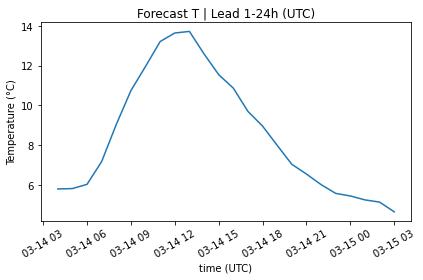

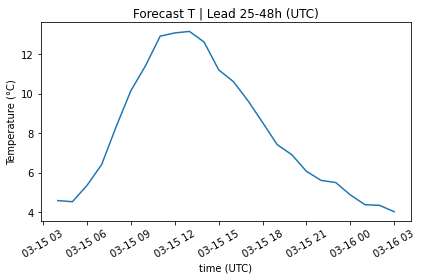

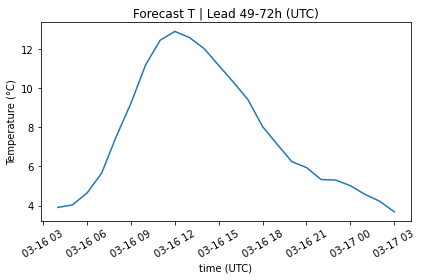

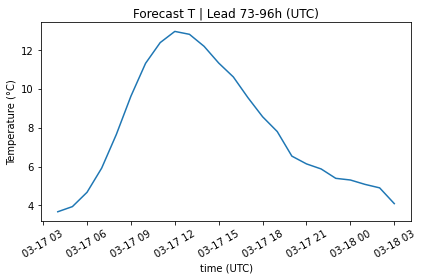

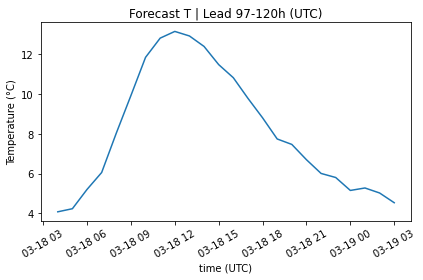

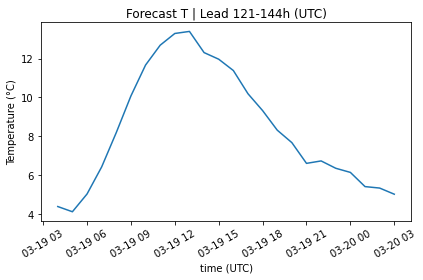

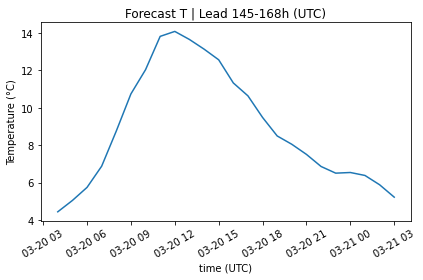

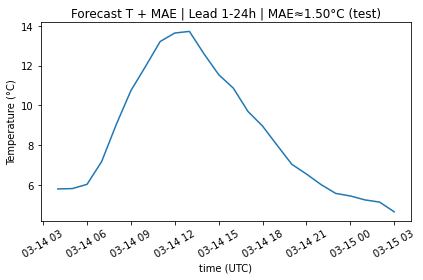

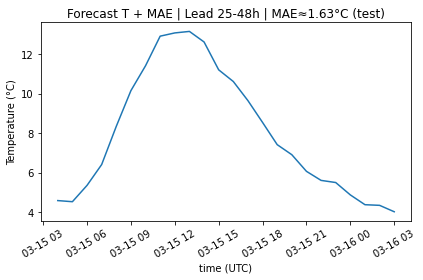

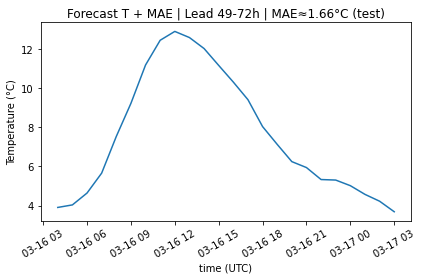

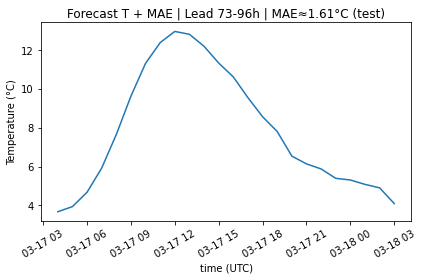

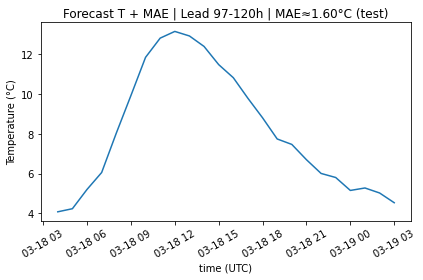

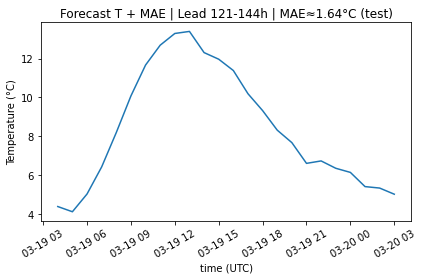

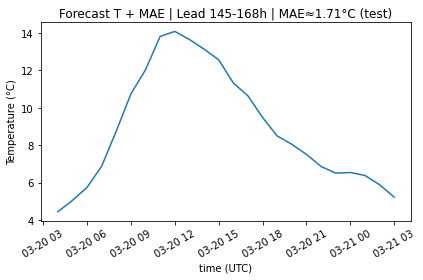

In [14]:
# =========================================
# Plot 14 figures (7 plain + 7 with MAE)
# =========================================
def plot_forecast_segments(forecast: pd.Series,
                           segments: List[Tuple[int,int]],
                           mae_seg: List[float],
                           mode: str = "plain"):
    """
    Plot segmented forecast figures

    mode:
      - "plain": forecast only
      - "mae"  : forecast + MAE in title
    """
    for i, (a,b) in enumerate(segments):
        seg = forecast.iloc[a-1:b]

        plt.figure()
        plt.plot(seg.index, seg.values)

        if mode == "plain":
            plt.title(f"Forecast T | Lead {a}-{b}h (UTC)")
        elif mode == "mae":
            plt.title(f"Forecast T + MAE | Lead {a}-{b}h | MAE≈{mae_seg[i]:.2f}°C (test)")
        else:
            raise ValueError("mode must be 'plain' or 'mae'")

        plt.xlabel("time (UTC)")
        plt.ylabel("Temperature (°C)")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

# Draw figures
plot_forecast_segments(forecast, segments, mae_seg_model, mode="plain")  # 7 figures
plot_forecast_segments(forecast, segments, mae_seg_model, mode="mae")    # 7 figures